In [3]:
import mne
import pandas as pd
import numpy as np
from pathlib import Path

# === Config ===
DATASET_ROOT = Path(r"C:\project\EEG projects\ds006104")
TIME_WINDOW = 10.0  # seconds after phoneme onset

# === Initialize empty list to collect all rows ===
all_trials = []

subject_dirs = sorted(DATASET_ROOT.glob("sub-*"))[:5]

# === Loop over all subject folders ===
for subject_dir in subject_dirs:
    subject = subject_dir.name
    eeg_path = subject_dir / "ses-02" / "eeg"
    
    edf_file = next(eeg_path.glob("*_task-singlephoneme_eeg.edf"), None)
    tsv_file = next(eeg_path.glob("*_task-singlephoneme_events.tsv"), None)
    
    if not edf_file or not tsv_file:
        print(f"Skipping {subject}: files missing")
        continue

    print(f"Processing {subject}...")

    # Load data
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    events_df = pd.read_csv(tsv_file, sep="\t")

    # Filter stimulus phonemes
    stim_df = events_df[events_df['trial_type'] == 'stimulus'].copy()
    stim_df = stim_df.dropna(subset=['phoneme1'])  # keep only valid phonemes

    sfreq = raw.info['sfreq']

    for _, row in stim_df.iterrows():
        onset_sample = int(row['onset'] * sfreq)
        duration_samples = int(TIME_WINDOW * sfreq)
        end_sample = onset_sample + duration_samples

        if end_sample > raw.n_times:
            continue  # skip if out of bounds

        eeg_segment = raw.get_data(start=onset_sample, stop=end_sample)

        # Append to dataset
        all_trials.append({
            'subject': subject,
            'phoneme': row['phoneme1'],
            'eeg': eeg_segment
        })

# === Convert to DataFrame (metadata only) ===
df_metadata = pd.DataFrame([
    {'subject': t['subject'], 'phoneme': t['phoneme']}
    for t in all_trials
])

print("Total trials collected:", len(all_trials))
print(df_metadata.head())


Processing sub-S01...
Processing sub-S02...
Processing sub-S03...
Processing sub-S04...
Processing sub-S05...
Total trials collected: 990
   subject phoneme
0  sub-S01       a
1  sub-S01       i
2  sub-S01       e
3  sub-S01       u
4  sub-S01       o


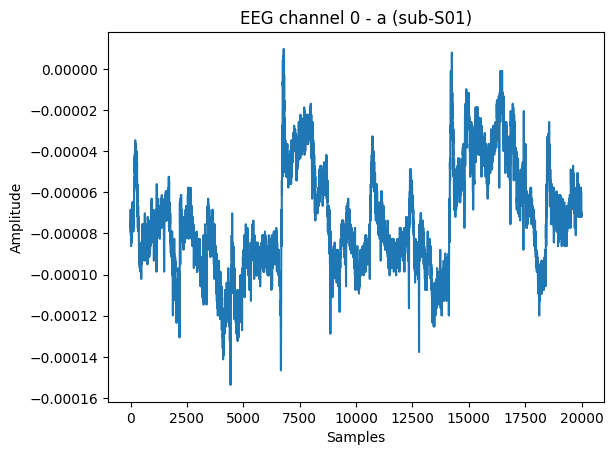

In [6]:
import matplotlib.pyplot as plt

plt.plot(all_trials[0]['eeg'][0])  # Plot channel 0
plt.title(f"EEG channel 0 - {all_trials[0]['phoneme']} ({all_trials[0]['subject']})")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()
